In [1]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import os
import glob  # For finding files
import matplotlib.pyplot as plt

print("All libraries imported successfully.")

All libraries imported successfully.


Loading all original samples from ./raw_data for visualization...

--- Plotting: Caline_Voice_Approve.wav ---


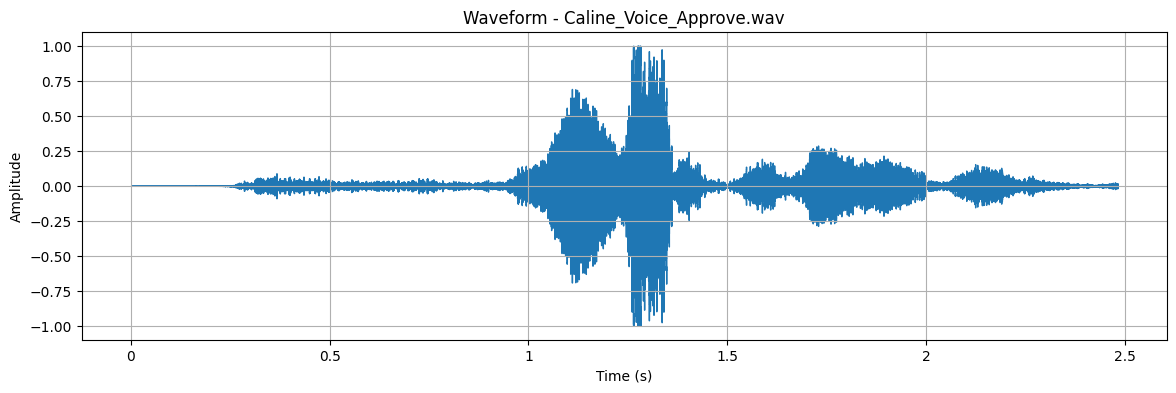

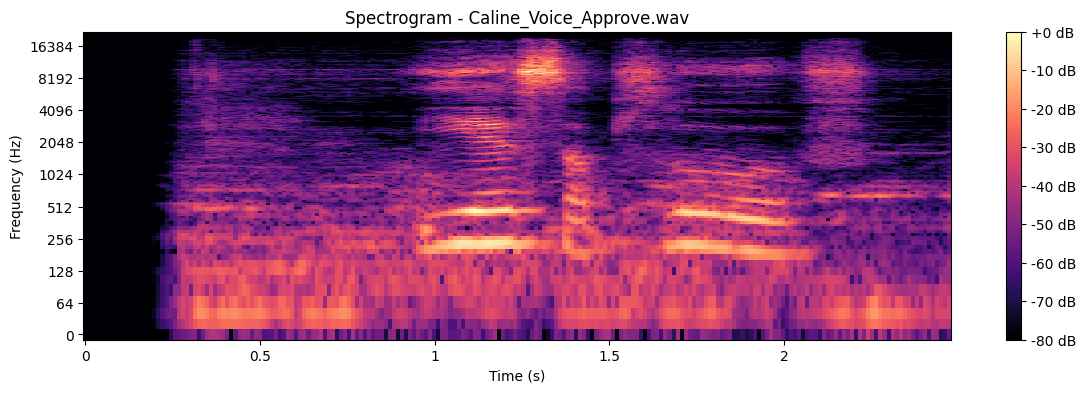


--- Plotting: Caline_Voice_Confirm.wav ---


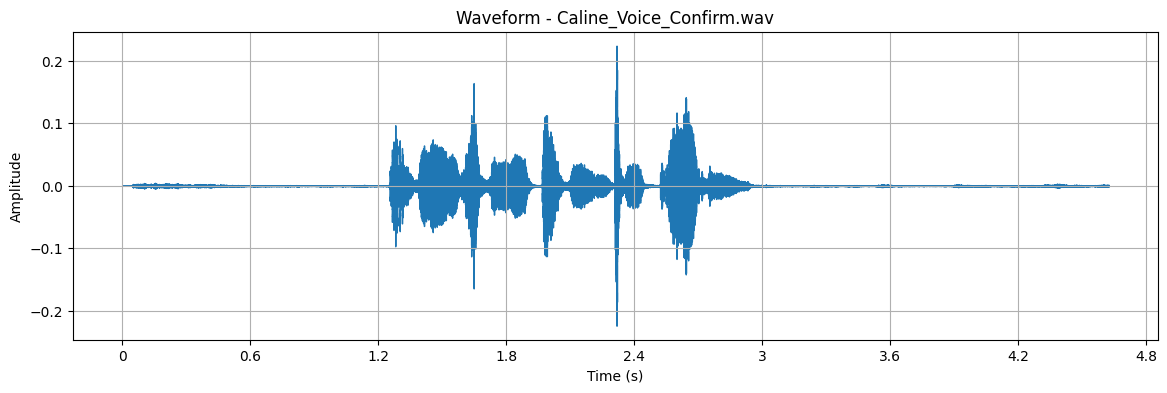

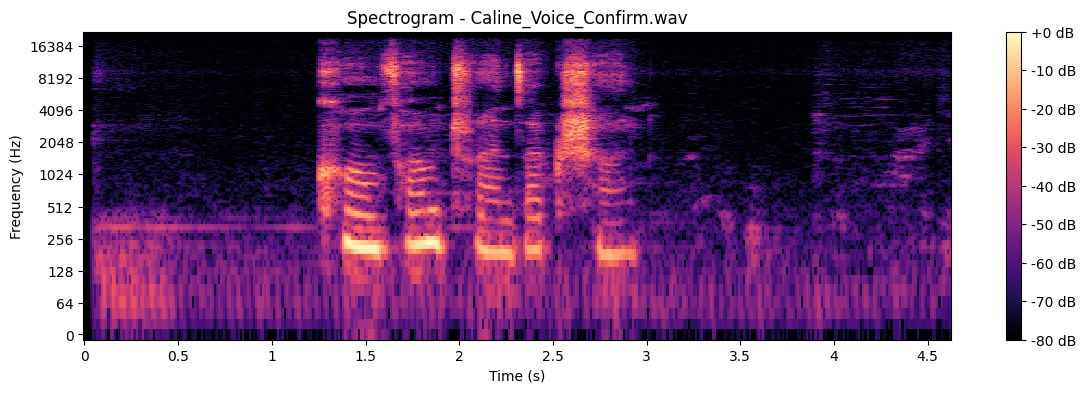


--- Plotting: Keza_Confirm_Transaction.wav ---


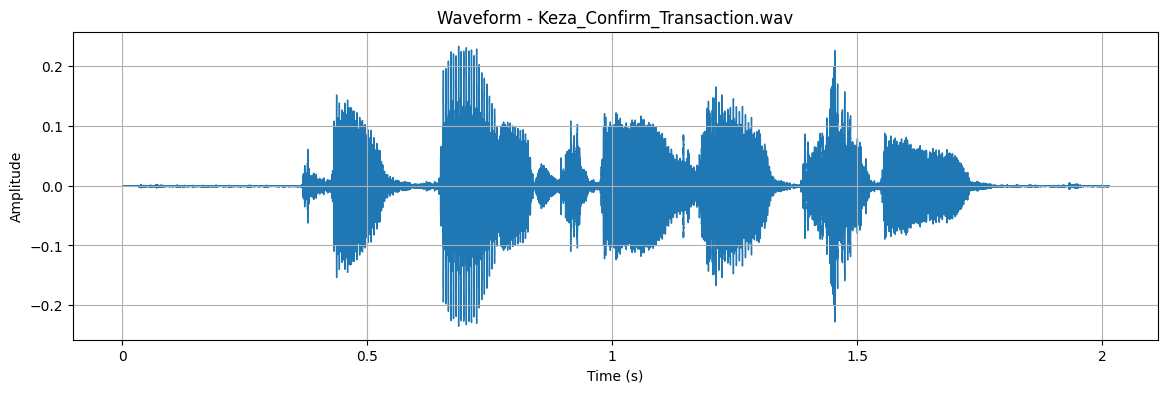

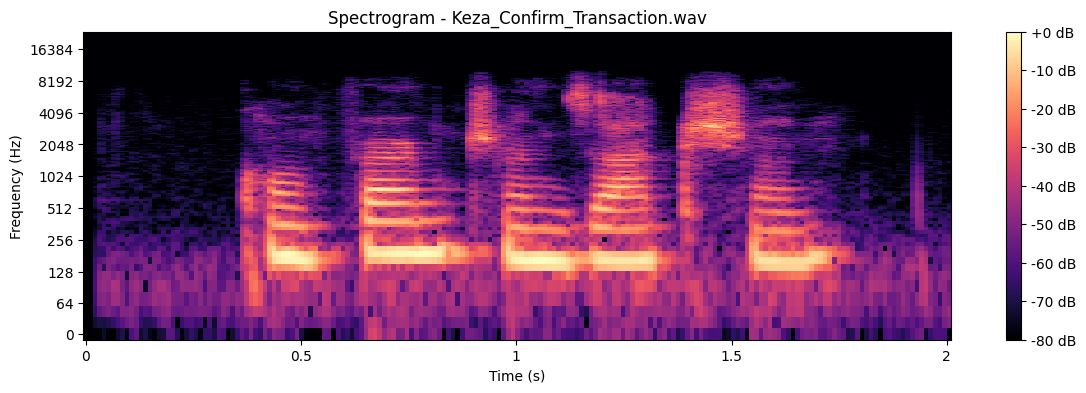


--- Plotting: Keza_Yes_Approve.wav ---


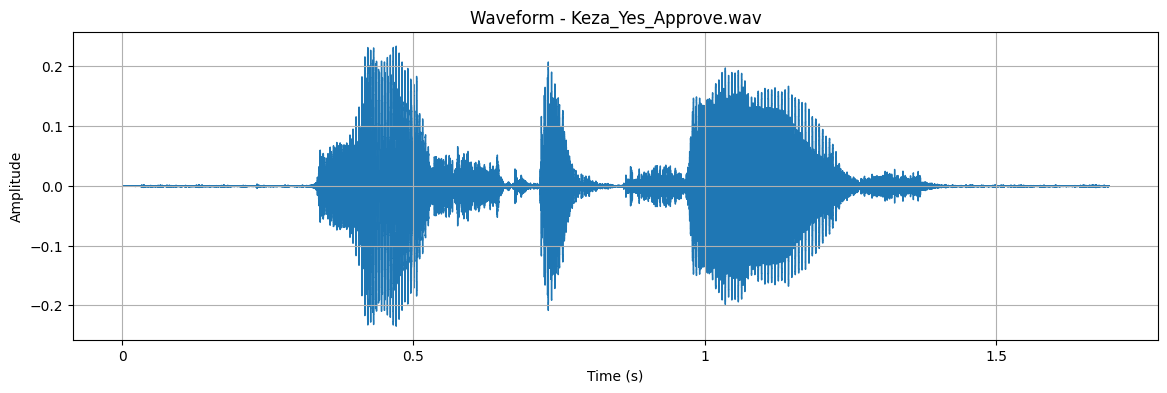

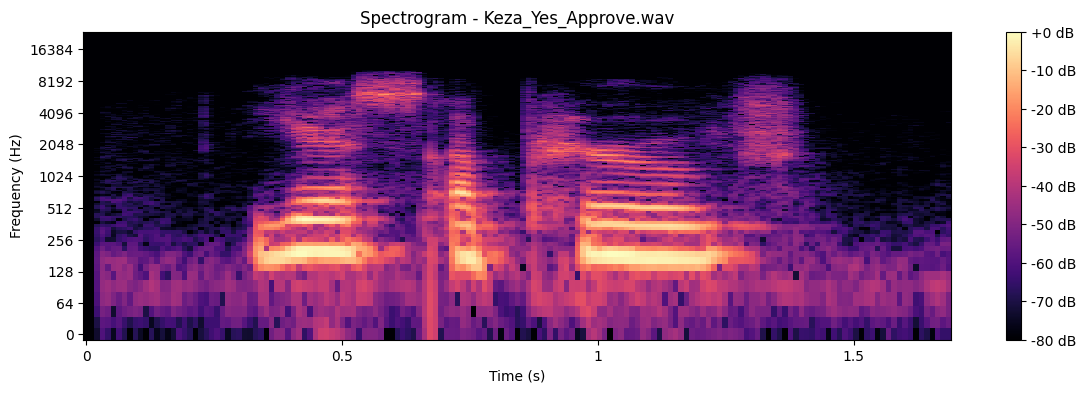


--- Plotting: SengaKabare_Voice_Approve.wav ---


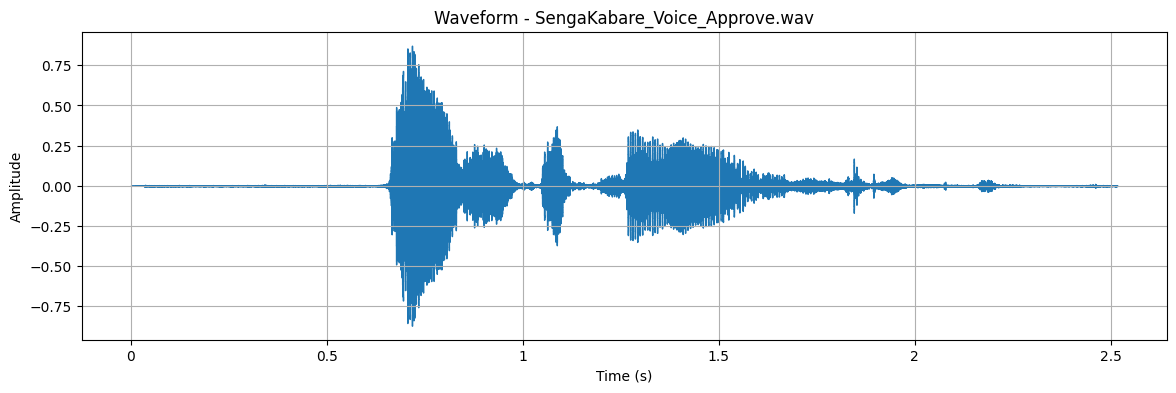

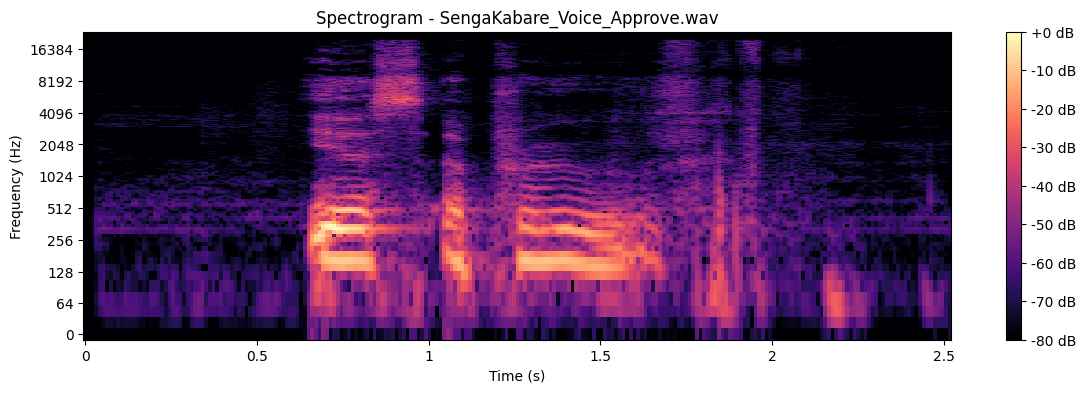


--- Plotting: SengaKabare_voice_transaction.wav ---


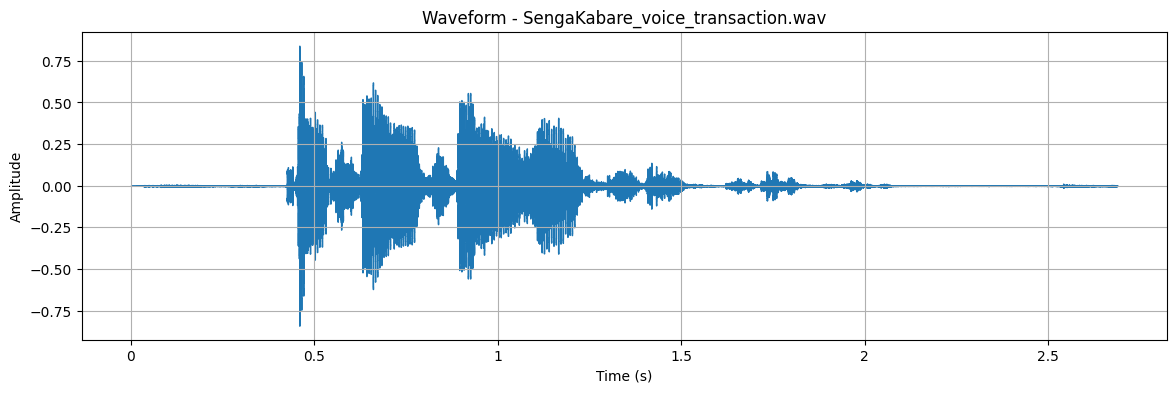

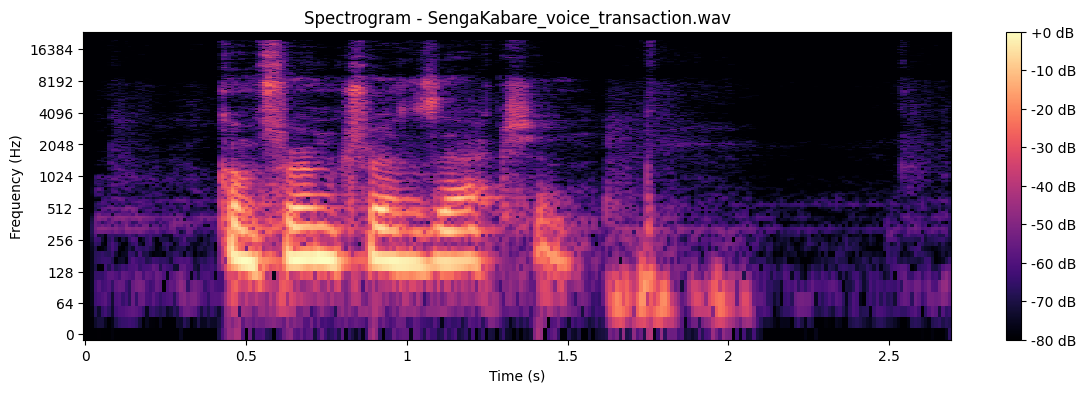


--- Plotting: Theodora_Voice_Approve.wav ---


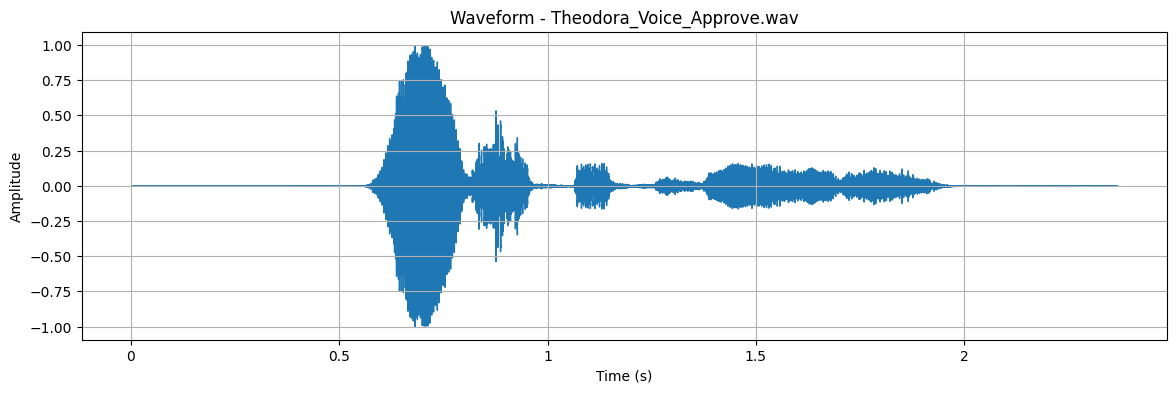

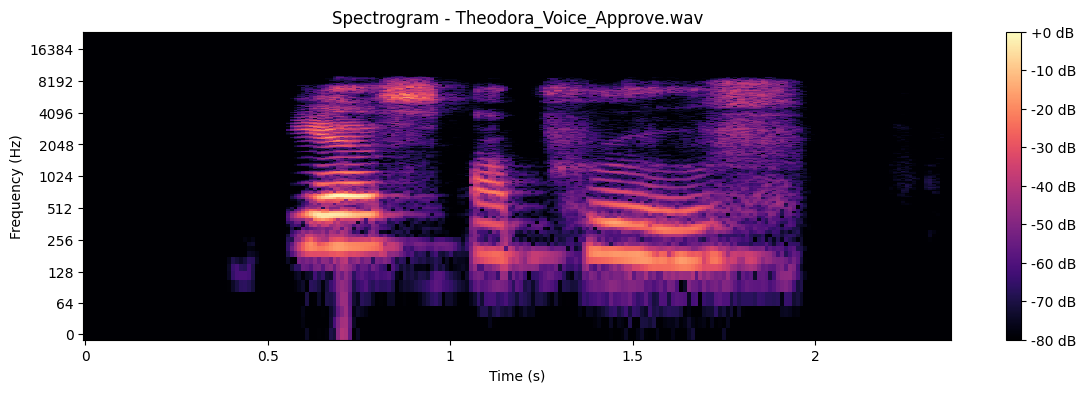


--- Plotting: Theodora_Voice_ConfirmTransaction.wav ---


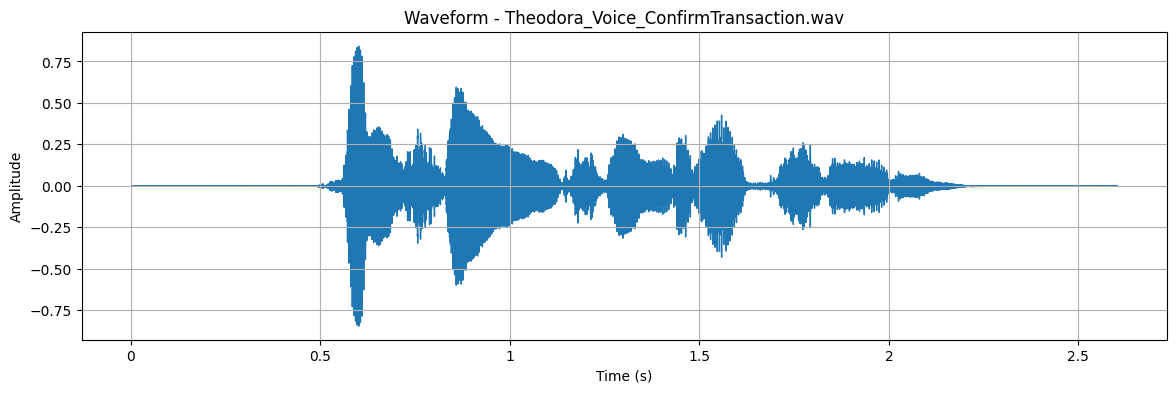

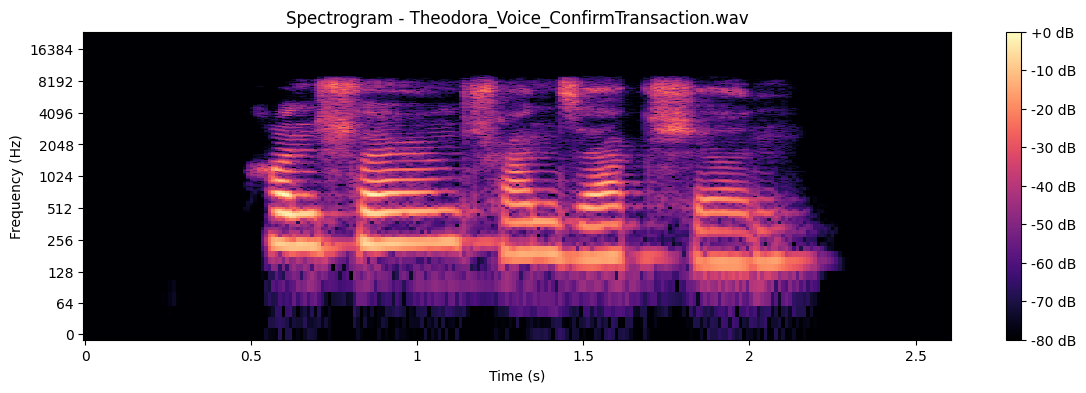


--- Phase A: All original samples have been plotted. ---


In [2]:
# --- PHASE A: VISUALIZE ALL ORIGINAL SAMPLES (EDA) ---

RAW_AUDIO_DIR = "./raw_data" 
print(f"Loading all original samples from {RAW_AUDIO_DIR} for visualization...")

# Loop through all .wav files
for file_path in glob.glob(os.path.join(RAW_AUDIO_DIR, "*.wav")): 
    
    filename = os.path.basename(file_path)
    
    # --- Load File ---
    try:
        audio, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue
    
    print(f"\n--- Plotting: {filename} ---")
    
    # --- 1. Plot Waveform ---
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform - {filename}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # --- 2. Plot Spectrogram ---
    S_db = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    plt.figure(figsize=(14, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {filename}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

print("\n--- Phase A: All original samples have been plotted. ---")

In [3]:
# --- 1. DEFINE HELPER FUNCTIONS ---

def augment_add_noise(audio_data, noise_factor=0.005):
    """
    Augmentation #1: Adds random noise.
    """
    noise = np.random.randn(len(audio_data))
    augmented_data = audio_data + noise_factor * noise
    return np.clip(augmented_data, -1., 1.) 

def augment_pitch_shift_up(audio_data, sample_rate, n_steps=3):
    """
    Augmentation #2: Shifts the pitch UP.
    """
    return librosa.effects.pitch_shift(y=audio_data, sr=sample_rate, n_steps=n_steps)

def augment_time_stretch(audio_data, rate=0.8):
    """
    Augmentation #3: Stretches time (slows down audio).
    """
    return librosa.effects.time_stretch(y=audio_data, rate=rate)

def augment_pitch_shift_down(audio_data, sample_rate, n_steps=-3):
    """
    Augmentation #4: Shifts the pitch DOWN.
    """
    return librosa.effects.pitch_shift(y=audio_data, sr=sample_rate, n_steps=n_steps)

def augment_time_shift(audio_data, sample_rate, shift_ms=100):
    """
    Augmentation #5: Shifts the audio to the right by a random amount.
    This simulates the speaker starting to talk at different times.
    """
    shift_samples = int(sample_rate * shift_ms / 1000)
    # Get a random shift between 0 and shift_samples
    random_shift = np.random.randint(0, shift_samples)
    # np.roll "rolls" the array, padding with silence (0s)
    return np.roll(audio_data, random_shift)

def augment_change_amplitude(audio_data, rate=0.7):
    """
    Augmentation #6: Makes the audio quieter (or louder).
    Simulates distance from the mic.
    """
    return audio_data * rate

def extract_features(audio_data, sample_rate):
    """
    Extracts the 3 features required by the rubric:
    1. MFCCs
    2. Spectral Roll-off
    3. Energy (RMS)
    """
    
    # 1. MFCCs (40 coefficients)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    # 2. Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
    rolloff_mean = np.mean(rolloff)
    
    # 3. Energy (Root Mean Square)
    rms = librosa.feature.rms(y=audio_data)
    rms_mean = np.mean(rms)
    
    # Combine all features into a single 1D array (40+1+1=42 features)
    features = np.hstack((mfccs_mean, rolloff_mean, rms_mean))
    
    return features

print("Helper functions for 6 augmentations and feature extraction are defined.")

Helper functions for 6 augmentations and feature extraction are defined.


In [4]:
# --- PHASE C: PROCESS, AUGMENT, AND EXTRACT FEATURES ---

RAW_AUDIO_DIR = "./raw_data" 
all_features_list = [] # This will hold our 56 feature sets

print("Starting feature extraction loop (1 original + 6 augmentations per file)...")

# This loop will iterate 8 times (once for each original file)
for file_path in glob.glob(os.path.join(RAW_AUDIO_DIR, "*.wav")): 
    
    filename = os.path.basename(file_path)
    
    # --- Get Label ---
    try:
        label = filename.split('_')[0]
    except:
        print(f"Skipping {filename}: Could not determine label.")
        continue

    # --- Load File ---
    try:
        audio, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue
    
    print(f"Processing: {filename}... (This will create 7 feature sets)")
    
    # --- 2. APPLY AUGMENTATIONS ---
    # We call the 6 functions you defined in Phase B
    audio_noise = augment_add_noise(audio)
    audio_pitch_up = augment_pitch_shift_up(audio, sr)
    audio_stretch = augment_time_stretch(audio)
    audio_pitch_down = augment_pitch_shift_down(audio, sr)
    audio_time_shift = augment_time_shift(audio, sr)
    audio_quiet = augment_change_amplitude(audio)
    
    # --- 3. EXTRACT FEATURES from all 7 versions ---
    
    # We create a list of all 7 audio versions to loop through
    audio_versions = [
        audio, 
        audio_noise, 
        audio_pitch_up, 
        audio_stretch, 
        audio_pitch_down, 
        audio_time_shift, 
        audio_quiet
    ]
    
    # Extract features from all 7 versions
    for version in audio_versions:
        features = extract_features(version, sr)
        all_features_list.append({
            "features": features, 
            "label": label
        })

print("\n--- Phase C: All 56 feature sets have been extracted. ---")

Starting feature extraction loop (1 original + 6 augmentations per file)...
Processing: Caline_Voice_Approve.wav... (This will create 7 feature sets)
Processing: Caline_Voice_Confirm.wav... (This will create 7 feature sets)
Processing: Keza_Confirm_Transaction.wav... (This will create 7 feature sets)
Processing: Keza_Yes_Approve.wav... (This will create 7 feature sets)
Processing: SengaKabare_Voice_Approve.wav... (This will create 7 feature sets)
Processing: SengaKabare_voice_transaction.wav... (This will create 7 feature sets)
Processing: Theodora_Voice_Approve.wav... (This will create 7 feature sets)
Processing: Theodora_Voice_ConfirmTransaction.wav... (This will create 7 feature sets)

--- Phase C: All 56 feature sets have been extracted. ---


--- Showcase: Demonstrating all 6 augmentations on Theodora_Voice_ConfirmTransaction.wav ---


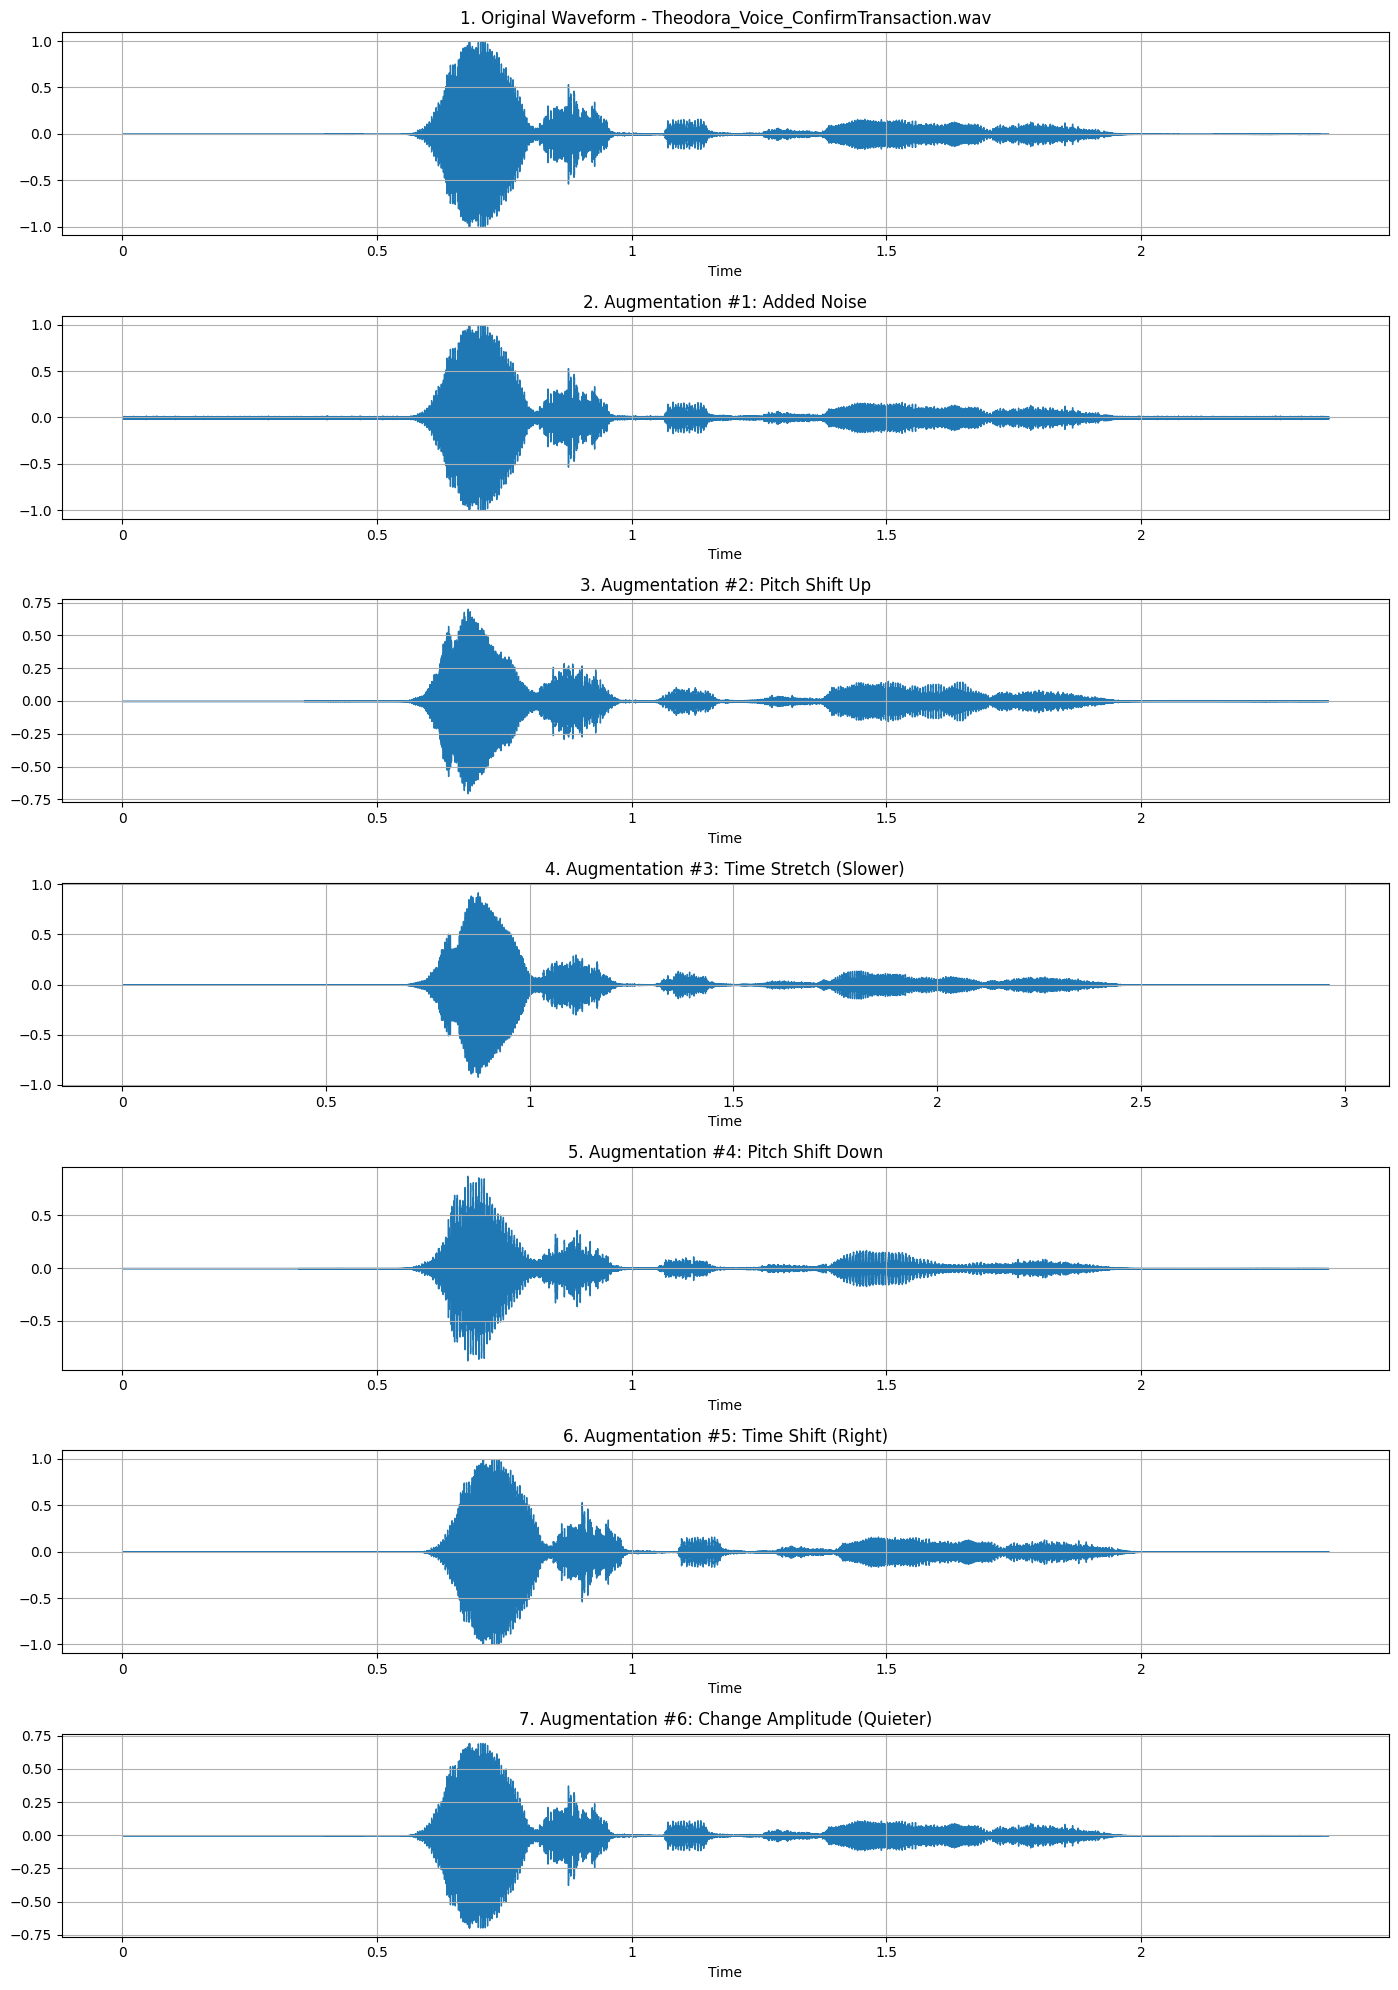

In [5]:
# --- PHASE B (Part 2): AUGMENTATION SHOWCASE ---
# We will take ONE file and plot all 6 augmentations
# to demonstrate they work for the report.

# *** ACTION: Pick one of your 8 files as the example ***
EXAMPLE_FILE = 'raw_data/Theodora_Voice_Approve.wav' 

print(f"--- Showcase: Demonstrating all 6 augmentations on {filename} ---")

# 1. Load the example file
try:
    audio, sr = librosa.load(EXAMPLE_FILE, sr=None)
except Exception as e:
    print(f"Error loading {EXAMPLE_FILE}: {e}")

# 2. Apply all 6 augmentations
audio_noise = augment_add_noise(audio)
audio_pitch_up = augment_pitch_shift_up(audio, sr)
audio_stretch = augment_time_stretch(audio)
audio_pitch_down = augment_pitch_shift_down(audio, sr)
audio_time_shift = augment_time_shift(audio, sr)
audio_quiet = augment_change_amplitude(audio)

# 3. Plot all 7 versions in one figure
plt.figure(figsize=(14, 20)) # A tall figure to fit all 7 plots

# Plot 1: Original
plt.subplot(7, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title(f'1. Original Waveform - {filename}')
plt.grid(True)

# Plot 2: Noise
plt.subplot(7, 1, 2)
librosa.display.waveshow(audio_noise, sr=sr)
plt.title(f'2. Augmentation #1: Added Noise')
plt.grid(True)

# Plot 3: Pitch Up
plt.subplot(7, 1, 3)
librosa.display.waveshow(audio_pitch_up, sr=sr)
plt.title(f'3. Augmentation #2: Pitch Shift Up')
plt.grid(True)

# Plot 4: Time Stretch
plt.subplot(7, 1, 4)
librosa.display.waveshow(audio_stretch, sr=sr)
plt.title(f'4. Augmentation #3: Time Stretch (Slower)')
plt.grid(True)

# Plot 5: Pitch Down
plt.subplot(7, 1, 5)
librosa.display.waveshow(audio_pitch_down, sr=sr)
plt.title(f'5. Augmentation #4: Pitch Shift Down')
plt.grid(True)

# Plot 6: Time Shift
plt.subplot(7, 1, 6)
librosa.display.waveshow(audio_time_shift, sr=sr)
plt.title(f'6. Augmentation #5: Time Shift (Right)')
plt.grid(True)

# Plot 7: Quiet
plt.subplot(7, 1, 7)
librosa.display.waveshow(audio_quiet, sr=sr)
plt.title(f'7. Augmentation #6: Change Amplitude (Quieter)')
plt.grid(True)

plt.tight_layout() # Prevents titles from overlapping
plt.show()

In [6]:
# --- PHASE D: SAVE FEATURES TO CSV ---

if not all_features_list:
    print("Error: No features were extracted. Check your raw_data folder.")
elif len(all_features_list) != 56:
    print(f"Warning: Expected 56 feature sets, but found {len(all_features_list)}.")
    print("Proceeding anyway, but please check your code or raw_data folder.")
else:
    print("Found 56 feature sets, as expected.")

# Convert list of dictionaries to DataFrame
X = [item["features"] for item in all_features_list]
y = [item["label"] for item in all_features_list]
feature_df = pd.DataFrame(X)
feature_df['label'] = y

# Re-order columns to have 'label' first (cleaner for the report)
cols = ['label'] + [col for col in feature_df.columns if col != 'label']
feature_df = feature_df[cols]

# Save to CSV
output_path = "audio_features.csv"
feature_df.to_csv(output_path, index=False)

print(f"\nSuccessfully saved all features to {output_path}!")
print(f"Total original files: {len(all_features_list) // 7}")
print(f"Total samples in CSV (1 Original + 6 Augmentations): {len(feature_df)}")
print("\nPreview of your final dataset:")
print(feature_df.head())

Found 56 feature sets, as expected.

Successfully saved all features to audio_features.csv!
Total original files: 8
Total samples in CSV (1 Original + 6 Augmentations): 56

Preview of your final dataset:
    label           0          1          2          3          4          5  \
0  Caline -334.505554  80.363083  31.960703  38.601078 -23.618664  34.220261   
1  Caline -260.563600  43.895285  31.947165  27.325303  -3.676716  17.533075   
2  Caline -364.707275  71.703117  40.607567  18.398798 -13.093484  25.410641   
3  Caline -369.101685  76.483719  32.255466  37.095928 -22.565018  32.748333   
4  Caline -378.706421  83.849281  20.367743  55.950260 -26.915783  31.403313   

           6          7          8  ...        32        33        34  \
0 -17.425180   8.843948   4.115203  ...  1.578511  3.304145  1.244644   
1  -8.202426   4.238915   5.444781  ...  1.083966  2.685566  1.075323   
2 -21.749084  17.807522  -9.590775  ...  2.000575  3.260718  2.635558   
3 -16.571386   7.898382